# Assignment 3 - Variational Autoencoders (VAEs)

## **1**. **Theory** **Questions**:

### Q1: Why is the KL Divergence term important in the VAE loss function?

The KL Divergence term in the VAE loss function is crucial because it ensures that the latent space of the model is both regular and useful for generating new data. Specifically, it:

Regularizes the Latent Space: It pushes the learned distribution of the latent variables to be close to a standard normal distribution, preventing overfitting.

Ensures Smoothness: It makes the latent space smooth and continuous, which is essential for generating new samples that are realistic and varied.

Balances the Model: It helps balance the trade-off between good reconstruction of the input data and maintaining a probabilistic structure that facilitates generation of new data.

Facilitates Sampling: By aligning the latent distribution with the assumed normal prior, it simplifies the process of sampling new data points from the model.



### Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

The reparameterization trick is crucial for enabling backpropagation through the stochastic layers of a Variational Autoencoder (VAE). It efficiently computes gradients by separating the randomness from the network parameters. This technique reformulates random sampling into a deterministic function that incorporates external randomness, avoiding direct sampling from the latent distribution. By doing so, it makes the network fully differentiable end-to-end, allowing gradients to propagate through the sampling mechanism. This transformation permits the use of standard gradient-based optimization methods to train the VAE effectively.


### Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?

A Variational Autoencoder (VAE) uses a probabilistic latent space instead of a fixed latent space to model the underlying data distribution more effectively. This approach allows the VAE to capture the inherent uncertainty and variability in the data, enabling it to generate new samples that are diverse yet consistent with the input data characteristics. By using a probabilistic latent space, the VAE can also perform more robust feature extraction and data interpolation. This flexibility makes it particularly useful in tasks like generative modeling, where capturing the complexity of data distributions is crucial.

### Q4: What role does KL Divergence play in ensuring a smooth latent space?

KL Divergence in a Variational Autoencoder (VAE) plays a crucial role in smoothing the latent space by penalizing deviations of the learned distribution from the prior distribution, typically a standard normal. This regularization encourages the latent variables to be well-organized and continuous, reducing overfitting and ensuring that similar inputs have similar representations in the latent space. The smoothness of the latent space is essential for effective interpolation and generation of new data points that are plausible and varied, reflecting the true underlying data distribution.







# **2.Coding Task**
### **TASK 1**

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # Output: 32 x 16 x 16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # Output: 64 x 8 x 8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # Output: 128 x 4 x 4
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 128, 4, 4)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = torch.sigmoid(self.deconv3(z))  # Sigmoid for normalization to [0, 1]
        return z

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

latent_dim = 128  # Dimension of the latent space
vae = VAE(latent_dim)


In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


100%|██████████| 170M/170M [00:05<00:00, 31.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# Move the model to the GPU before training
vae.cuda()  # Add this line

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_divergence
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

for epoch in range(1, 11):  # 10 epochs
    train(epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1755.094971
Train Epoch: 1 [6400/50000 (13%)]	Loss: 648.978210
Train Epoch: 1 [12800/50000 (26%)]	Loss: 654.474121
Train Epoch: 1 [19200/50000 (38%)]	Loss: 549.750671
Train Epoch: 1 [25600/50000 (51%)]	Loss: 638.778625
Train Epoch: 1 [32000/50000 (64%)]	Loss: 602.792969
Train Epoch: 1 [38400/50000 (77%)]	Loss: 546.983215
Train Epoch: 1 [44800/50000 (90%)]	Loss: 603.914429
====> Epoch: 1 Average loss: 638.8893
Train Epoch: 2 [0/50000 (0%)]	Loss: 507.358185
Train Epoch: 2 [6400/50000 (13%)]	Loss: 643.063049
Train Epoch: 2 [12800/50000 (26%)]	Loss: 577.963745
Train Epoch: 2 [19200/50000 (38%)]	Loss: 562.645874
Train Epoch: 2 [25600/50000 (51%)]	Loss: 569.149780
Train Epoch: 2 [32000/50000 (64%)]	Loss: 518.267822
Train Epoch: 2 [38400/50000 (77%)]	Loss: 581.572693
Train Epoch: 2 [44800/50000 (90%)]	Loss: 528.244751
====> Epoch: 2 Average loss: 554.9897
Train Epoch: 3 [0/50000 (0%)]	Loss: 578.714417
Train Epoch: 3 [6400/50000 (13%)]	Loss: 533.508240
Train

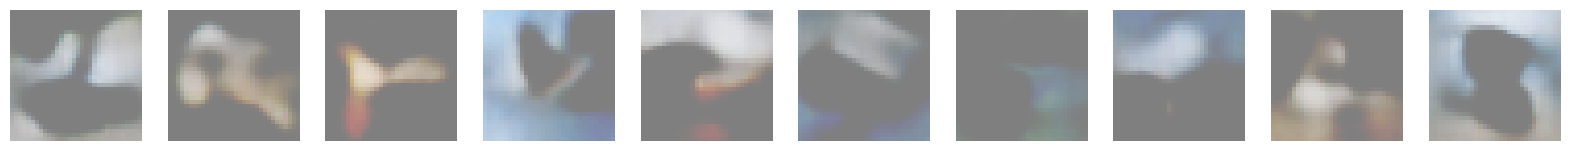

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_images(model, num_images=10):
    """Generates and displays images using the trained VAE model.

    Args:
        model: The trained VAE model.
        num_images: The number of images to generate.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Sample random latent vectors
        z = torch.randn(num_images, model.encoder.fc_mu.out_features).cuda()

        # Generate images from the latent vectors
        sample = model.decoder(z).cpu()

    # Display the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes):
        # Denormalize the image
        img = sample[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        ax.imshow(img)
        ax.axis('off')  # Hide axes
    plt.show()


# Assuming 'vae' is your trained model
generate_images(vae, num_images=10)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define VAE for CIFAR-10
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # 32x32x3 = 3072 for CIFAR-10

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))  # Output shape: (batch_size, 3072)

    def forward(self, x):
        x = x.view(-1, self.input_dim)  # Flatten CIFAR-10 images
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function for CIFAR-10 VAE
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 3072), reduction='sum')  # Use MSE instead of BCE
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


# Training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')



In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize for better training
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(input_dim=3072, hidden_dim=512, latent_dim=128).to(device)  # Adjusted input and hidden sizes
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Train the VAE
for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)

Files already downloaded and verified
Epoch 1, Loss: 672.2636925
Epoch 2, Loss: 603.139079765625
Epoch 3, Loss: 582.257035546875
Epoch 4, Loss: 570.084919375
Epoch 5, Loss: 562.79558859375
Epoch 6, Loss: 558.54283515625
Epoch 7, Loss: 555.655486875
Epoch 8, Loss: 553.804939609375
Epoch 9, Loss: 552.159446875
Epoch 10, Loss: 551.085895625


In [25]:

def generate_images(model, num_images=10, latent_dim=128):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space
        z = torch.randn(num_images, latent_dim).to(device)  # Ensure it's on the right device
        # Decode to generate images
        generated_images = model.decode(z).cpu().numpy()  # Convert to NumPy array

    # Reshape the images (batch_size, 3, 32, 32)
    generated_images = generated_images.reshape(num_images, 3, 32, 32)

    # Normalize images to [0,1] for display
    generated_images = (generated_images - generated_images.min()) / (generated_images.max() - generated_images.min())

    # Plot generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        axs[i].axis('off')
    plt.show()

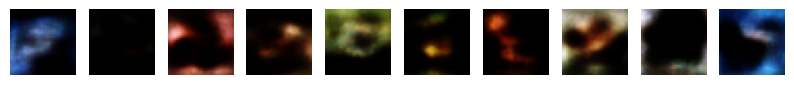

In [26]:
generate_images(vae, num_images=10, latent_dim=128)


### TASK 2

In [9]:
def get_latent_vector(model, image):
    """Get the latent vector for a given image"""
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        mu, logvar = model.encode(image)
        z = model.reparameterize(mu, logvar)
    return z

def interpolate_latent_vectors(z1, z2, steps=10):
    """Create interpolated points between two latent vectors"""
    interpolated = []
    for alpha in torch.linspace(0, 1, steps):
        interpolated.append(z1 * (1 - alpha) + z2 * alpha)
    return torch.stack(interpolated)

def visualize_interpolation(model, img1, img2, steps=10):
    """Visualize interpolation between two images"""
    model.eval()

    # Get latent vectors for both images
    z1 = get_latent_vector(model, img1)
    z2 = get_latent_vector(model, img2)

    # Generate interpolated images
    interpolated_z = interpolate_latent_vectors(z1, z2, steps)

    with torch.no_grad():
        interpolated_images = model.decode(interpolated_z)

    # Plot original images and interpolation
    plt.figure(figsize=(15, 3))

    # Plot all images including original and interpolated
    all_images = torch.cat([img1.unsqueeze(0).to(device),
                          interpolated_images,
                          img2.unsqueeze(0).to(device)])

    fig, axes = plt.subplots(1, steps + 2, figsize=((steps + 2) * 1.5, 1.5))
    for i, ax in enumerate(axes):
        img = all_images[i].cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.axis('off')
        if i == 0:
            ax.set_title('Source')
        elif i == steps + 1:
            ax.set_title('Target')
        else:
            ax.set_title(f'{i/(steps+1):.1f}')

    plt.tight_layout()
    plt.show()

def interpolate_between_classes(model, train_loader, class1, class2, steps=10):
    """Interpolate between two specific classes from CIFAR-10"""
    # Get one image from each class
    img1, img2 = None, None

    for images, labels in train_loader:
        mask1 = labels == class1
        mask2 = labels == class2
        if img1 is None and mask1.any():
            img1 = images[mask1][0]
        if img2 is None and mask2.any():
            img2 = images[mask2][0]
        if img1 is not None and img2 is not None:
            break

    visualize_interpolation(model, img1, img2, steps)


In [16]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Example usage:
print("Interpolating between different classes...")

# Make sure the model is defined before usage, e.g.,
# model = ConvVAE(latent_dim).to(device) # If using ConvVAE
# Or load a saved model if it was previously trained

# Assuming you're using the ConvVAE from earlier
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
torch.manual_seed(42)

# Assuming ConvVAE is already defined
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128

# Define the ConvVAE class before using it
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x4x4
            nn.ReLU(),
            nn.Flatten()  # 128*4*4 = 2048
        )

        # Latent space
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 3x32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = ConvVAE(latent_dim).to(device)  # Define the model here
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Interpolating between different classes...
Files already downloaded and verified



Interpolating between airplane and automobile:


<Figure size 1500x300 with 0 Axes>

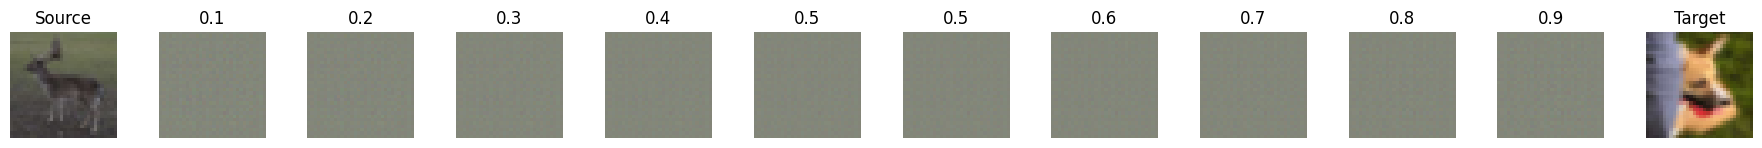

In [13]:
print("\nInterpolating between airplane and automobile:")
interpolate_between_classes(model, train_loader, 4, 5)


Interpolating between airplane and automobile:


<Figure size 1500x300 with 0 Axes>

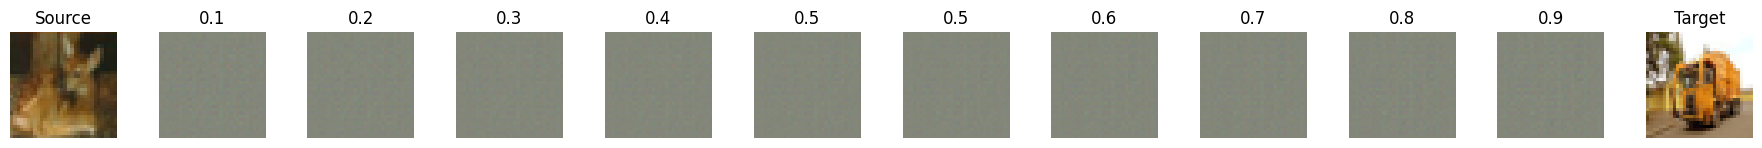

In [17]:
print("\nInterpolating between airplane and automobile:")
interpolate_between_classes(model, train_loader, 4, 9)